# Obtén rápidamente y de manera sencilla el modelo de tu proceso

## Modelo de Primer Orden Más Tiempo Muerto (FOPDT)

Autor: MSc. Ing. Josmell Córdova Claros (correo: josmell.cordova@pucp.edu.pe)  
(Basado en el código original desarrollado por *APMonitor*, url=https://apmonitor.com/pdc/index.php/Main/FirstOrderOptimization)

**Objetivo:** programa que permite obtener los parámetros de un modelo FOPDT:
* Ganancia del proceso $(K)$
* Constante de tiempo $(\tau)$
* Tiempo muerto ($\theta$) 

**Método:** a través de una *regresión no lineal* de la respuesta escalón utilizando un algoritmo de optimización que permite minimizar la suma de los errores al cuadrado.

## Importar librerias importantes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# %matplotlib notebook
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

## Cargar los datos de la prueba escalón o curva de reacción

* Formato del archivo: *.csv  
* Columna 1 = t = tiempo (t) [min] (Nota: deben estar espaciados en intervalos *constantes* de tiempo)  
* Columna 2 = u = salida del controlador (OP) [%]  
* Columna 3 = yp = variable de proceso o variable controlada (PV) [% escala]  

In [2]:
#data = pd.read_csv('tanque_escalon_prueba.CSV',delimiter=',') # cargamos el archivo csv
#data = pd.read_csv('tanque_prueba_escalon.csv',delimiter=',') # cargamos el archivo csv
url = 'https://raw.githubusercontent.com/josmellcordova/ModeloFOPDT/main/tanque_prueba_escalon.csv'
#columnas = ['t', 'OP', 'PV']
data = pd.read_csv(url)

t = data['t'].to_numpy()
u = data['OP'].to_numpy()
yp = data['PV'].to_numpy()
u0 = u[0]
yp0 = yp[0]

## Graficar la respuesta escalón o curva de reacción

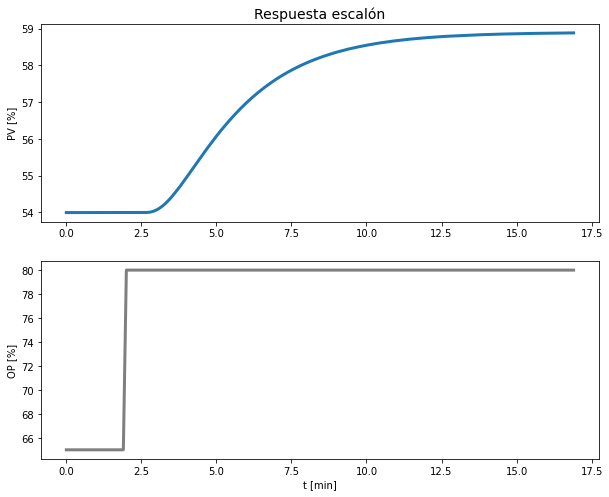

In [3]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(t,yp, color="C0", linewidth=3)
plt.title('Respuesta escalón', fontsize=14)
plt.ylabel('PV [%]')
plt.subplot(2,1,2)
plt.plot(t,u, color="C7", linewidth=3)
plt.ylabel('OP [%]')
plt.xlabel('t [min]')
plt.savefig("prueba_escalon.png")
plt.show()

## Explorar los datos

Mostrar los primeros 10 datos 

In [4]:
data.head(10) 

,t,OP,PV
0,0.0,65,53.992
1,0.1,65,53.992
2,0.2,65,53.992
3,0.3,65,53.992
4,0.4,65,53.992
5,0.5,65,53.992
6,0.6,65,53.992
7,0.7,65,53.992
8,0.8,65,53.992
9,0.9,65,53.992


Generar una estadística descriptiva para los datos

In [5]:
data.describe() 

,t,OP,PV
count,170.00000,170.000000,170.000000
mean,8.45000,78.235294,57.155259
std,4.92189,4.847123,1.933589
min,0.00000,65.000000,53.991000
25%,4.22500,80.000000,55.203750
50%,8.45000,80.000000,58.211000
75%,12.67500,80.000000,58.790750
max,16.90000,80.000000,58.883000


In [6]:
data.info() # muestra el número de columnas y el tipo de dato

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       170 non-null    float64
 1   OP      170 non-null    int64  
 2   PV      170 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 4.1 KB


In [7]:
data.shape # muestra el número de filas y columnas

(170, 3)

## Programa para optimizar los parámetros del modelo FOPDT

In [8]:
# Obtener el número de pasos de tiempo 
ns = len(t)
# Tiempo de muestreo
delta_t = t[1]-t[0]
# Creamos una interpolación lineal de "u" vs "t"
uf = interp1d(t,u)

In [9]:
# Definir una función para el modelo FOPDT   
def fopdt(y,t,uf,Km,taum,thetam):
    # argumentos de la función
    #  y      = salida
    #  t      = tiempo
    #  uf     = función lineal de entrada (para desplazamiento en el tiempo)
    #  Km     = ganancia del modelo
    #  taum   = constante de tiempo del modelo
    #  thetam = tiempo muerto del modelo
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error con la extrapolación: ' + str(t))
        um = u0
    # Calcular la derivada
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt


In [10]:
# Simular el modelo FOPDT con x=[Km,taum,thetam]
def sim_model(x):
    # Argumentos de entrada
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # Almacenamiento para los valores del modelo
    ym = np.zeros(ns)  # modelo
    # Condición inicial
    ym[0] = yp0
    # Bucle a través de los pasos de tiempo   
    for i in range(0,ns-1):
        ts = [delta_t*i,  delta_t*(i+1)] # (Nota: debe estar espaciados en intervalos constantes de tiempo)
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1] = y1[-1]
    return ym


In [11]:
# Definir el objetivo (suma de errores al cuadrado o SCE)
def objective(x):
    # Modelo simulado
    ym = sim_model(x)
    # Calcular el objetivo
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    # error al cuadrado
    # return result
    return obj

In [12]:
# Valores iniciales para los parametros del modelo FOPDT
x0 = np.zeros(3)
x0[0] = 0.3 # Km
x0[1] = 1.5 # taum
x0[2] = 0.5 # thetam

In [13]:
# Mostrar el valor objetivo (SCE) inicial
print('SSE inicial: ' + str(objective(x0)))

SSE inicial: 103.76394619879378


In [14]:
# Optimizar los parámetros del modelo FOPDT (Km, taum, thetam)
# Límites para los parámetros del modelo FOPDT
bnds = ((-1.0e3, 1.0e3), (0.001, 1.0e3), (0.0, 1.0e3))
solution = minimize(objective,x0,method='SLSQP',bounds=bnds)
x = solution.x

In [15]:
# Mostrar el valor objetivo (SCE) final (optimizado)
print('SCE Final: ' + str(objective(x))) # (Nota: este comando puede demorarse un cierto tiempo)

SCE Final: 0.5576666459049184


In [16]:
# Mostrar los parámetros del modelo FOPDT optimizados
print('Parámetros del modelo FOPDT optimizados:')
print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

Parámetros del modelo FOPDT optimizados:
Kp: 0.3318019389737889
taup: 2.789419084834055
thetap: 1.4432214312089917


## Comparación de los datos reales y el modelo FOPDT

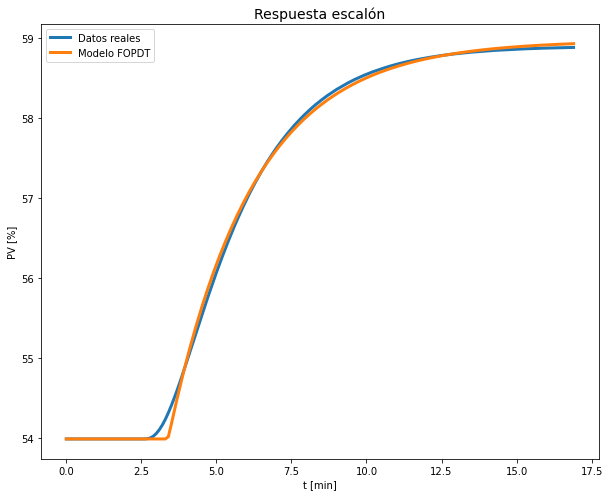

In [17]:
# Modelo calculado a partir de los parámetros optimizados
ym2 = sim_model(x)
# Graficar los resultados
plt.figure(figsize=(10,8))
plt.plot(t, yp, label='Datos reales', color="C0", linewidth=3)
plt.plot(t, ym2, label='Modelo FOPDT', color="C1", linewidth=3)
plt.ylabel('PV [%]')
plt.legend(loc='best')
plt.xlabel('t [min]')
plt.title('Respuesta escalón', fontsize=14)
plt.savefig("escalon_modelo.png",dpi=400)
plt.show()

## Coeficiente de determinación (R2)

Mide el grado de ajuste entre los datos reales y el modelo.

In [18]:
from sklearn.metrics import r2_score 
r2 = r2_score(yp, ym2) 
print('R2: ', r2)


R2:  0.9991174085439548
